# 1. 전처리 부문

## 1.1 기본 라이브러리 입력 

(1) 확장 라이브러리 설치

In [ ]:
# 지도 출력 관련 데이터 
!pip install -q geopandas

# 엑셀 관련 데이터 
!pip3 install xlrd
!pip3 install openpyxl

(2) 라이브러리 불러오기

In [58]:
# 기본 전처리 라이브러리
import pandas as pd
import numpy as np

import os

# kakao 좌표 관련 요청 라이브러리
import json
import requests

## 1.2 데이터별(전처리)

### 1.2.1 기본 자료 데이터 PATH

In [14]:
path = "./data"
file_list = os.listdir(path)

### 1.2.2 "자동차 등록 자료 통계.xlsx" 관련 자료 전처리

#### 1.2.2.1  한글 제목 변환
엑셀 데이터의 경우 판다스에서 정확하게 잘 처리하지 못하는 경우나 읽기 어려운 경우와 한글의 경우 인코딩 문제가 일부 있어, 관련 부분 제목 변환<p>
    
2020년 01월 자동차 등록자료 통계 --> 2020_01_Car_Info 로 치환

In [15]:
car_file_list = [file for file in file_list if file.endswith('자동차_등록자료_통계.xlsx')]

for car_file in car_file_list:
    src = os.path.join(path, car_file)
    chg_name = car_file.split('_')[0][0:4] + '_' + car_file.split('_')[1][0:-1] + '_' + 'Car_Info' + '.xlsx'
    dst = os.path.join(path, chg_name)
    os.rename(src, dst)

file_list = os.listdir(path)
car_file_list = [file for file in file_list if file.endswith('Car_Info.xlsx')]

변환이 잘되어 파일로 떨어졌는지 확인한다.

In [16]:
print(car_file_list)

['2018_01_Car_Info.xlsx', '2018_02_Car_Info.xlsx', '2018_03_Car_Info.xlsx', '2018_04_Car_Info.xlsx', '2018_05_Car_Info.xlsx', '2018_06_Car_Info.xlsx', '2018_07_Car_Info.xlsx', '2018_08_Car_Info.xlsx', '2018_09_Car_Info.xlsx', '2018_10_Car_Info.xlsx', '2018_11_Car_Info.xlsx', '2018_12_Car_Info.xlsx', '2019_01_Car_Info.xlsx', '2019_02_Car_Info.xlsx', '2019_03_Car_Info.xlsx', '2019_04_Car_Info.xlsx', '2019_05_Car_Info.xlsx', '2019_06_Car_Info.xlsx', '2019_07_Car_Info.xlsx', '2019_08_Car_Info.xlsx', '2019_09_Car_Info.xlsx', '2019_10_Car_Info.xlsx', '2019_11_Car_Info.xlsx', '2019_12_Car_Info.xlsx', '2020_01_Car_Info.xlsx', '2020_02_Car_Info.xlsx', '2020_03_Car_Info.xlsx', '2020_04_Car_Info.xlsx', '2020_05_Car_Info.xlsx', '2020_06_Car_Info.xlsx', '2020_07_Car_Info.xlsx', '2020_08_Car_Info.xlsx', '2020_09_Car_Info.xlsx', '2020_10_Car_Info.xlsx']


#### 1.2.1.2 불필요한 데이터 제거 및 2개 데이터로 변환
* 목적 1. 친환경 차량과 비 친환경 차량을 구별하는 인자 추가 
* 목적 2. 불필요 데이터 제거 (의미 없는 값)

(1) 여러개의 엑셀로 분할된 데이터를 한개의 dataframe 으로 합치는 작업

In [17]:
# 각 파일을 1개씩 불러와 전처리 실시 
count = 0
for car_file in car_file_list:
    
    target_file = os.path.join(path, car_file)
    df = pd.read_excel(target_file, engine='openpyxl', sheet_name="10.연료별_등록현황", header = 2)
    df = df.rename(columns={'Unnamed: 2' : '합계'}) # 합계의 경우, 해당 줄에 컬럼명이 없어 추가 함 
    
    if count == 0:
        car_list_df = pd.DataFrame(columns=df.columns)    # 최종 전처리 프레임
        car_list_df['year'] = 0
        car_list_df['month'] = 0
    
    # 소계인 데이터만 추출 (업무용 / 비업무용 등은 제거)
    for i in range(1, len(df) - 17, 17):
        tmp = df[i:i+17].fillna(method='pad')[-1:]
        tmp['year'] = car_file.split('_')[0]
        tmp['month'] = car_file.split('_')[1]
        car_list_df = pd.concat([car_list_df, tmp])
    count += 1

(2) 불필요한 데이터 제거

In [18]:
# 소계 중 한대도 없는 차량의 경우 제거 
car_list_df = tmp_df[tmp_df['계'] != 0.0]

# 불필요한 행 제거 
car_list_df = tmp_df.drop('Unnamed: 21', axis=1

SyntaxError: unexpected EOF while parsing (<ipython-input-18-36de328551fb>, line 5)

(3) 친환경 / 비친환경 차량 구분

In [19]:
tmp_lst = list()
for tmp in car_list_df.연료별:
    if (tmp.find('수소') != -1 ) | (tmp.find('전기') != -1):
        tmp_lst.append('친환경')
    else : 
        tmp_lst.append('비친환경')

car_list_df['친환경'] = tmp_lst

(4) 나중에 사용할 것을 대비하여, csv 파일로 생성 해둠 

In [20]:
#csv 형태로 변환 저장 [한글 깨짐 방지를 위해 utf-8 설정]
car_list_df.to_csv(os.path.join(path, 'total_car_info.csv'),mode = 'w',encoding='utf-8-sig')

### 1.2.3 수소 충전소 데이터 처리

* 목표 1. 주소지를 다른 데이터와 합칠수 있게 시 / 도별로 나눈 데이터를 추가한다.
* 목표 2. 지도로 표시할수 있도록 좌표 값을 kakao api를 활용하여 추가한다.

In [49]:
path = "./data"
target_file = os.path.join(path, 'Hydrogen_chariging_station.csv')
hyd_charging_df = pd.read_csv(target_file, encoding='cp949')

In [50]:
hyd_charging_df

,No,충전소명,구분,공급방식,주소,충전소전화번호,용도,비고
0,1,현대자동차㈜ 환경기술연구소,저장식,튜브트레일러,경기 용인 기흥 마북로240번길 17-5(마북동),031-899-3022,연구용,NaN
1,2,한국가스공사 H2/HCNG복합충전소,제조식,개질(NG),인천 연수구 인천신항대로 960,032-810-0388,연구용,미가동
2,3,현대자동차㈜ 남양연구소,저장식,튜브트레일러,경기 화성 현대연구소로 150,NaN,연구용,NaN
3,4,에스앤디㈜-울산수소충전소,저장식,튜브트레일러,울산 남구 장생포고래로 317,052-226-6000,연구용,휴지
4,5,한국교통안전공단 자동차성능연구소,저장식,튜브트레일러,경기 화성 송산면 삼존로 200,031-369-1173,연구용,미가동
5,6,현대자동차㈜ 양재그린에너지스테이션,저장식,튜브트레일러,서울 서초구 바우뫼로12길 73,02-2058-1351,상업용,휴지
6,7,서울특별시 상암수소스테이션,제조식,개질(NG+매립가스),서울 마포구 하늘공원로 86,02-3151-0336,상업용,NaN
7,8,한국에너지기술연구원,제조식,수전해,전북 부안군 하서면 신재생에너지로 20-41,063-580-1670,연구용,휴지
8,9,㈜덕양 매암수소충전소,저장식,튜브트레일러,울산 남구 장생포고래로29번길 5,070-4421-1688,상업용,NaN
9,10,이엠솔루션㈜ 대구경북지점,제조식,수전해,대구 북구 조야로2길 41,055-239-9026,상업용,휴지


#### (1) 주소지를 분리한다. 
<p>주소지는 2가지 특징을 지니고 있다.</p>
<ol> 
    <li> 도에 속한 주소는 2가지 값을 지닌다.</li>
    <li> 시에 속한 주소는 1가지 값을 지닌다. </li>
</ol>
다른 데이터를 기준으로 시도 , 지역 구분으로 나누어 표기하기에 동일하게 표기한다. 

In [53]:
tmp_city = list()
tmp_location = list()
for address in hyd_charging_df.주소:
    tmp =  address.split()
    if tmp[0] in ('경기', '경기도', '강원', '강원도', '충남', '충북', '경남', '경북', '전북', '전남' ):
        tmp_city.append(tmp[0].replace('도', '').replace('시', ''))
        tmp_location.append(tmp[1].replace('시', '').replace('군', ''))
    else : 
        tmp_city.append(tmp[0].replace('시', '').replace('군', ''))
        tmp_location.append(tmp[0].replace('시', '').replace('군', ''))            

hyd_charging_df['시도'] = tmp_city
hyd_charging_df['지역'] = tmp_location

In [54]:
hyd_charging_df

,No,충전소명,구분,공급방식,주소,충전소전화번호,용도,비고,시도,지역
0,1,현대자동차㈜ 환경기술연구소,저장식,튜브트레일러,경기 용인 기흥 마북로240번길 17-5(마북동),031-899-3022,연구용,NaN,경기,용인
1,2,한국가스공사 H2/HCNG복합충전소,제조식,개질(NG),인천 연수구 인천신항대로 960,032-810-0388,연구용,미가동,인천,인천
2,3,현대자동차㈜ 남양연구소,저장식,튜브트레일러,경기 화성 현대연구소로 150,NaN,연구용,NaN,경기,화성
3,4,에스앤디㈜-울산수소충전소,저장식,튜브트레일러,울산 남구 장생포고래로 317,052-226-6000,연구용,휴지,울산,울산
4,5,한국교통안전공단 자동차성능연구소,저장식,튜브트레일러,경기 화성 송산면 삼존로 200,031-369-1173,연구용,미가동,경기,화성
5,6,현대자동차㈜ 양재그린에너지스테이션,저장식,튜브트레일러,서울 서초구 바우뫼로12길 73,02-2058-1351,상업용,휴지,서울,서울
6,7,서울특별시 상암수소스테이션,제조식,개질(NG+매립가스),서울 마포구 하늘공원로 86,02-3151-0336,상업용,NaN,서울,서울
7,8,한국에너지기술연구원,제조식,수전해,전북 부안군 하서면 신재생에너지로 20-41,063-580-1670,연구용,휴지,전북,부안
8,9,㈜덕양 매암수소충전소,저장식,튜브트레일러,울산 남구 장생포고래로29번길 5,070-4421-1688,상업용,NaN,울산,울산
9,10,이엠솔루션㈜ 대구경북지점,제조식,수전해,대구 북구 조야로2길 41,055-239-9026,상업용,휴지,대구,대구


#### (2) 위도 경도 추가하기

위도 경도는 주소지로 나온 정보를 kakao api를 활용하여 검색한 후 위도 경도를 획득한다. <p>
    
참고 URL : https://medium.com/@john_analyst/%ED%8C%8C%EC%9D%B4%EC%8D%AC%EC%9D%84-%ED%99%9C%EC%9A%A9%ED%95%9C-%EC%B9%B4%EC%B9%B4%EC%98%A4-api%EB%A1%9C-%EC%9C%84%EA%B2%BD%EB%8F%84-%EA%B5%AC%ED%95%98%EA%B8%B0-69bc51697753

RestAPI=	0f187fa9603bee6f574b613cdb8f525d <p>
code=OLlwbTIfs9G7Nxo1CWhVsLBftdt-dflEMvkxyqHa7AkMnlItQ45L700dPPRbTs6oWKhxpQo9dZsAAAF2JwbVTg <p>

https://kauth.kakao.com/oauth/token?grant_type=authorization_code&client_id=0f187fa9603bee6f574b613cdb8f525d&redirect_uri=http://localhost:8888&code=OLlwbTIfs9G7Nxo1CWhVsLBftdt-dflEMvkxyqHa7AkMnlItQ45L700dPPRbTs6oWKhxpQo9dZsAAAF2JwbVTg

auth 인증 성공
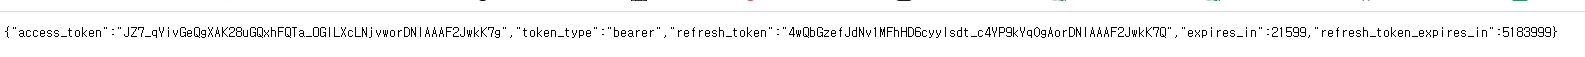

In [59]:
def getLatLng(addr):
    url = 'https://dapi.kakao.com/v2/local/search/address.json?query=' + addr
    headers = {"Authorization": "KakaoAK 073a393656181c6073880062d3507191"}
    result = json.loads(str(requests.get(url, headers=headers).text))
    match_first = result['documents'][0]['address']
    return float(match_first['y']), float(match_first['x'])
getLatLng('서울 마포구 모래내로1길 20')

(37.5656948713242, 126.903284318892)